## Introduction

### Business Question

In the realm of social media, understanding public sentiment is crucial for brands and companies. One pressing question is: **How can we use machine learning (ML) to determine if a tweet has positive or negative entiment?** This leads us to explore how we can leverage these models to gauge sentiment towards a company or brand effectively, and answer these common business questions: 
- How can companies leverage social media to get a better understanding of how people view their products?
- How can companies determine customer satisfaction regarding products or services?
- What is the product sentiment before and after a marketing campaign?


### Dataset Overview

To address these quations, we utilized a dataset comprising over 8000 tweets. Each tweet in the dataset is annotated with two key features:

- **Targeted Company**: The company or brand mentioned in the tweet.
- **Sentiment**: The sentiment expressed in the tweet, categorized as positive, neutral, or negative.

By analyzing this dataset, we aim to develop and evaluate models that can accurately classify tweet sentiment, providing valuable insights into public perception and helping brands better understand and respond to customer feedback.


In [186]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, silhouette_score,RocCurveDisplay, auc
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import WordNetLemmatizer
from imblearn.under_sampling import RandomUnderSampler
import nltk
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [187]:
data = pd.read_csv("data/data.csv", encoding='ISO-8859-1') # Handle most ascii values
data.head(1)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion


In [188]:
# Renaming
data = data.rename(columns={
    "tweet_text":"tweet",
    "emotion_in_tweet_is_directed_at":"directed_at",
    "is_there_an_emotion_directed_at_a_brand_or_product": "emotion"
})
data.head(1)

,tweet,directed_at,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion


# EDA

## is_na

In [189]:
data.isna().sum()

tweet             1
directed_at    5802
emotion           0
dtype: int64

In [190]:
# Removing the NaN tweet
data = data[data['tweet'].isna() == False]
data.isna().sum()

tweet             0
directed_at    5801
emotion           0
dtype: int64

In [191]:
# Lots of missing data here, fill directed_at with unknown 
data['directed_at'].fillna("Unknown", inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9092 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet        9092 non-null   object
 1   directed_at  9092 non-null   object
 2   emotion      9092 non-null   object
dtypes: object(3)
memory usage: 284.1+ KB


In [192]:
data.directed_at.value_counts()

directed_at
Unknown                            5801
iPad                                946
Apple                               661
iPad or iPhone App                  470
Google                              430
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: count, dtype: int64

In [193]:
data.emotion.value_counts()

emotion
No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

### Dropping "I can't tell" since it provides no value for encoding

In [194]:
data = data[data['emotion'] != "I can't tell"]
data.emotion.value_counts()

emotion
No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
Name: count, dtype: int64

### Removing duplicates, (This is why the tokenizer kept returning different lengths)

In [195]:
data = data.drop_duplicates(subset='tweet')
data

,tweet,directed_at,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",Unknown,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",Unknown,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,Unknown,No emotion toward brand or product


# Preprocess

### Remove @, #, https, link, rt, then tokenize and lemmatize

In [196]:
def preprocess_tweet(text):
    # Remove URLs
    text = re.sub(r'https?://\S+', '', text)
    
    # Remove @ and # 
    text = re.sub(r'[@#]\w+', '', text)
    
    # Remove non-alphanumeric characters (excluding punctuation)
    text = re.sub(r'[^\w\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Initialize the lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove the word "rt" and lemmatize other tokens, filtering out non-alphabetic tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token != 'rt'and token != 'link']
    
    # Join tokens back into a single string
    return ' '.join(lemmatized_tokens)


### Apply preprocess
Here we apply the preprocessing function above, as well as map sentiment (-1,0,1)

In [197]:
data['tweet'] = data['tweet'].apply(preprocess_tweet)

emotion_mapping = {
    "Negative emotion": -1,
    "No emotion toward brand or product": 0,
    "Positive emotion": 1
}

data['emotion'] = data['emotion'].map(emotion_mapping)

data

,tweet,directed_at,emotion
0,i have a iphone after hr tweeting at it wa dea...,iPhone,-1
1,know about awesome ipadiphone app that youll l...,iPad or iPhone App,1
2,can not wait for also they should sale them do...,iPad,1
3,i hope this year festival isnt a crashy a this...,iPad or iPhone App,-1
4,great stuff on fri marissa mayer google tim or...,Google,1
...,...,...,...
9088,ipad everywhere,iPad,1
9089,wave buzz we interrupt your regularly schedule...,Unknown,0
9090,google zeiger a physician never reported poten...,Unknown,0
9091,some verizon iphone customer complained their ...,Unknown,0


## Sum of sentiments chart 
Add all sentiment values together for each company to see how positive or negative the general feedback is, and display a word cloud to show the most frequent words

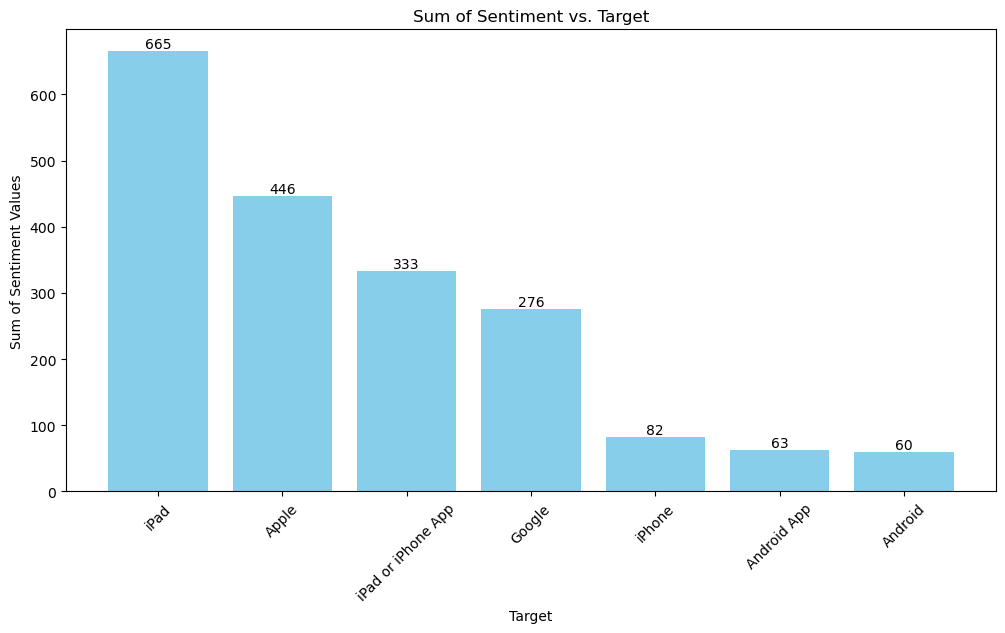

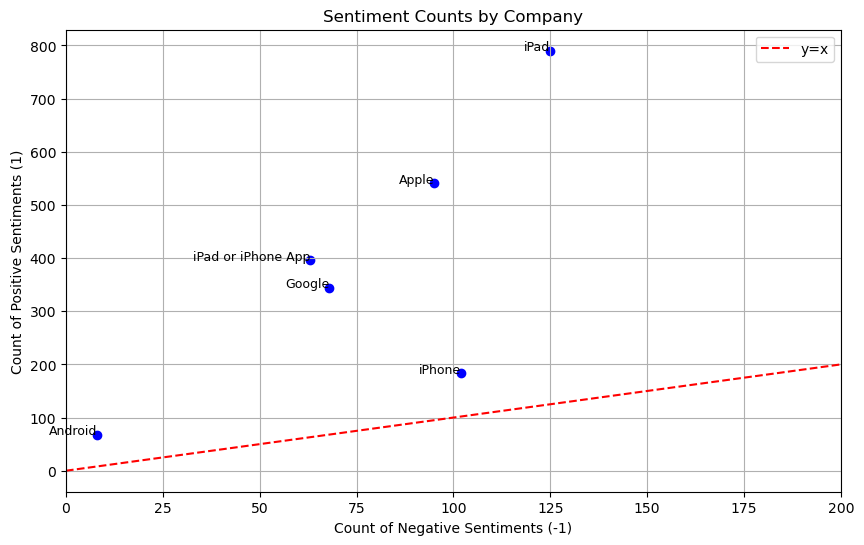

In [198]:
df = pd.DataFrame(data)


exclude_companies = ['Unknown', "Other Google product or service", 'Other Apple product or service']  # Add or remove company names as needed
sentiment_sum = df.groupby('directed_at')['emotion'].sum().reset_index()
sentiment_sum = sentiment_sum[~sentiment_sum['directed_at'].isin(exclude_companies)]

# Sort the DataFrame by the sum of sentiment values in descending order
sentiment_sum = sentiment_sum.sort_values(by='emotion', ascending=False)


plt.figure(figsize=(12, 6))
bars = plt.bar(sentiment_sum['directed_at'], sentiment_sum['emotion'], color='skyblue')

# Add labels and title
plt.xlabel('Target')
plt.ylabel('Sum of Sentiment Values')
plt.title('Sum of Sentiment vs. Target')

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center')  # va: vertical alignment, ha: horizontal alignment

plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.show()

df = pd.DataFrame(data)

exclude_companies = ['Unknown','Android App', "Other Google product or service", 'Other Apple product or service']
filtered_df = df[(df['emotion'] != 0) & (~df['directed_at'].isin(exclude_companies))]

# Count the occurrences of sentiment values for each company
sentiment_counts = filtered_df.groupby('directed_at')['emotion'].value_counts().unstack().fillna(0)
sentiment_counts.columns = ['Count of -1', 'Count of 1']

plt.figure(figsize=(10, 6))
plt.scatter(
    sentiment_counts['Count of -1'],  
    sentiment_counts['Count of 1'],   
    color='blue'
)

max_value = max(sentiment_counts['Count of -1'].max(), sentiment_counts['Count of 1'].max())
plt.plot([0, max_value], [0, max_value], 'r--', label='y=x')
plt.xlim(0, 200)

# Add labels and title
plt.xlabel('Count of Negative Sentiments (-1)')
plt.ylabel('Count of Positive Sentiments (1)')
plt.title('Sentiment Counts by Company')

# Add labels to each point
for company in sentiment_counts.index:
    plt.text(
        sentiment_counts.loc[company, 'Count of -1'], 
        sentiment_counts.loc[company, 'Count of 1'],
        company,
        fontsize=9,
        ha='right'
    )

plt.legend()  
plt.grid(True)  
plt.show()

# Class Imbalance

We have a 5x class imbalance between negative and positive emotions for our binary classifier. We will use random minority class oversampler to handle this imbalance, as well as updating our confusion matricies to be normalized. This will transform the confusion matrix to reflect normalized proportions, rather than absolute counts. By normalizing the confusion matrix, we can better understand the performance of the classifier in terms of precision, recall, and overall accuracy across the different classes. This approach helps to visualize the proportion of correct and incorrect classifications relative to the total number of instances in each class, which is particularly useful when dealing with imbalanced datasets.


In [199]:
data.emotion.value_counts()

emotion
 0    5372
 1    2968
-1     569
Name: count, dtype: int64

## Most common words, all sentiments, all targets and Word Cloud

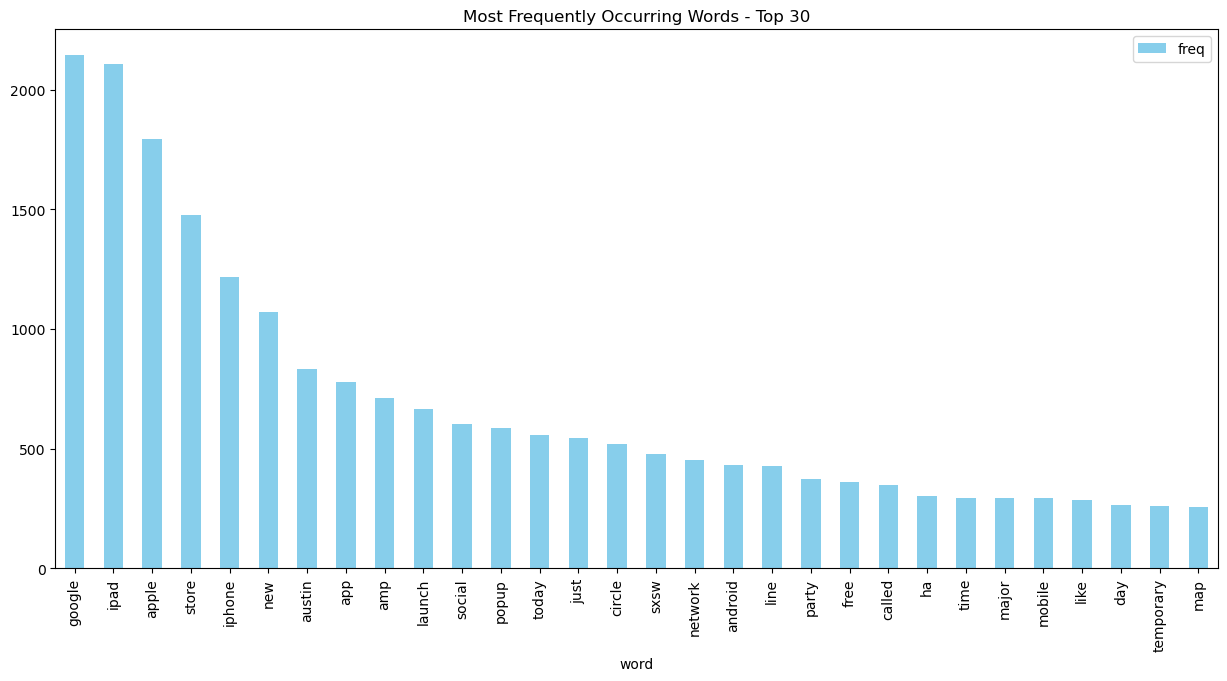

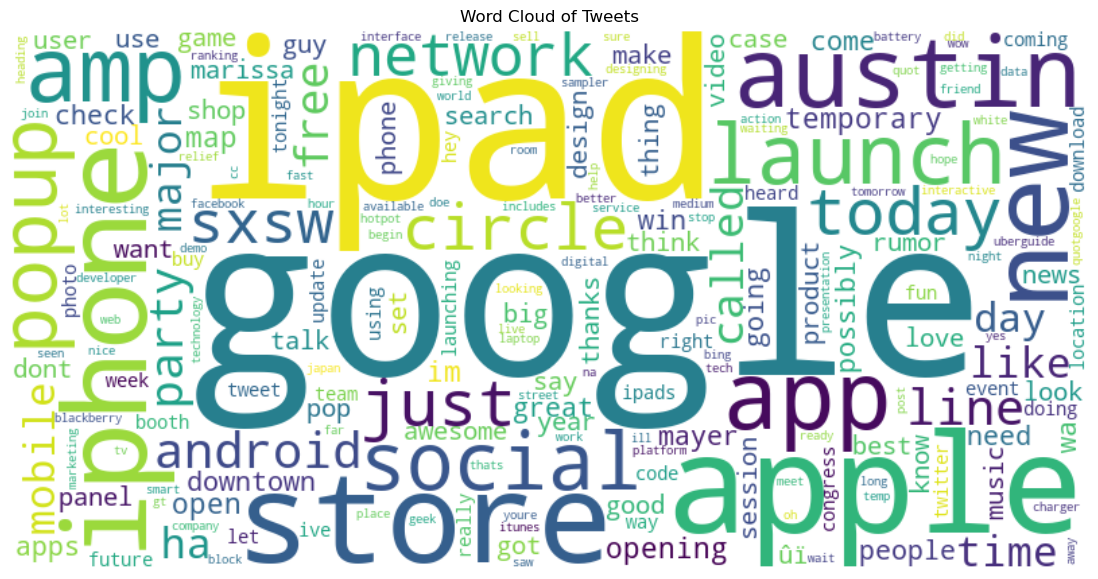

In [200]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data['tweet'])
sum_words = words.sum(axis=0)

# Create a list of words with their frequencies
words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

# Convert the list into a DataFrame
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

# Plot the top 30 most frequently occurring words
frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color='skyblue')
plt.title("Most Frequently Occurring Words - Top 30")
plt.show()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(words_freq))
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Tweets")
plt.show()

# Evaluation Function
Plot confusion matricies, as well as ROC AUC curves for the models. (Binary only)

In [201]:
def evaluate_model_binary(y_test, y_pred, clf_pipe):
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    disp = ConfusionMatrixDisplay.from_estimator(clf_pipe, X_test, y_test, display_labels=['Negative', 'Positive'],
               cmap=plt.cm.Blues, normalize='true')

    plt.title("Confusion Matrix")
    plt.show()

    # Probability scores for ROC
    y_pred_proba = clf_pipe.predict_proba(X_test)[:, 1]  # Ensure clf_pipe is a fitted pipeline
    
    # ROC AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    # Plot ROC Curve
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Binary Classifier (Baseline)
- MultinomialNB
- No class balancing
- No hypertuning

In [202]:
data_binary = data[data['emotion'] != 0]
X = data_binary['tweet']
y = data_binary['emotion']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Classification Report:
              precision    recall  f1-score   support

          -1       1.00      0.02      0.04       140
           1       0.84      1.00      0.92       745

    accuracy                           0.85       885
   macro avg       0.92      0.51      0.48       885
weighted avg       0.87      0.85      0.78       885



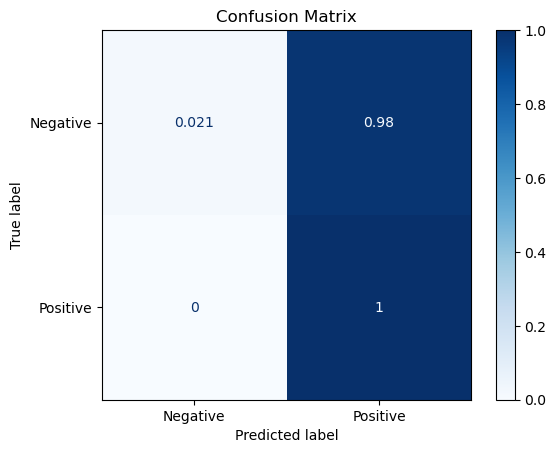

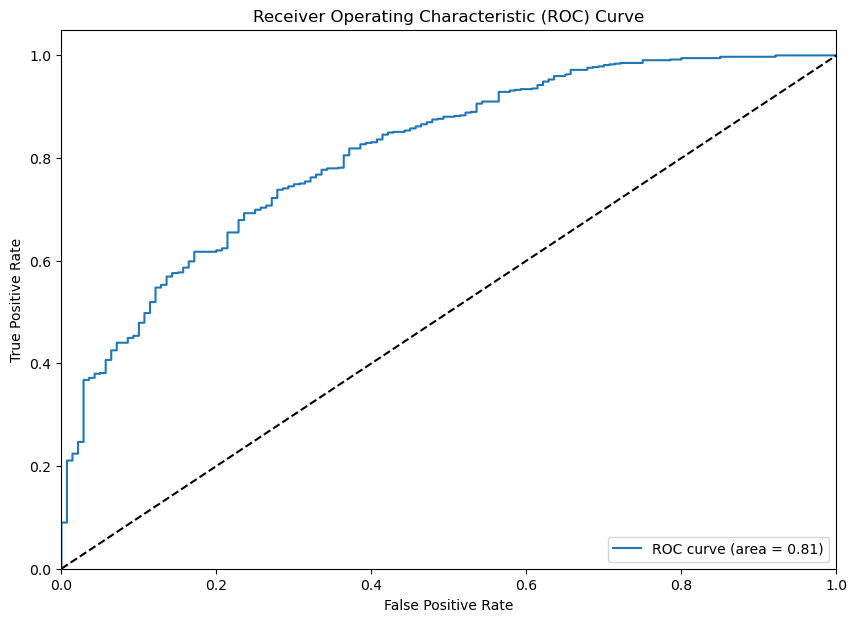

In [203]:
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay

clf_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer()),  # Text vectorization
    ('clf', MultinomialNB())  # Classification
])
clf_pipe.fit(X_train, y_train)
y_pred = clf_pipe.predict(X_test)


clf_pipe.fit(X_train, y_train)
y_pred = clf_pipe.predict(X_test)

evaluate_model_binary(y_test, y_pred, clf_pipe)

In [204]:
# Nearly a 5x class imbalance here
data_binary.emotion.value_counts()

emotion
 1    2968
-1     569
Name: count, dtype: int64

# MultinomialNB 
- Hypertuned
- Minority class oversampling

In [205]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:
{'clf__alpha': 1.0, 'clf__fit_prior': True, 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 5000, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 1), 'vectorizer__stop_words': None}
Classification Report:
              precision    recall  f1-score   support

          -1       0.49      0.69      0.57       140
           1       0.94      0.86      0.90       745

    accuracy                           0.84       885
   macro avg       0.71      0.78      0.73       885
weighted avg       0.87      0.84      0.85       885



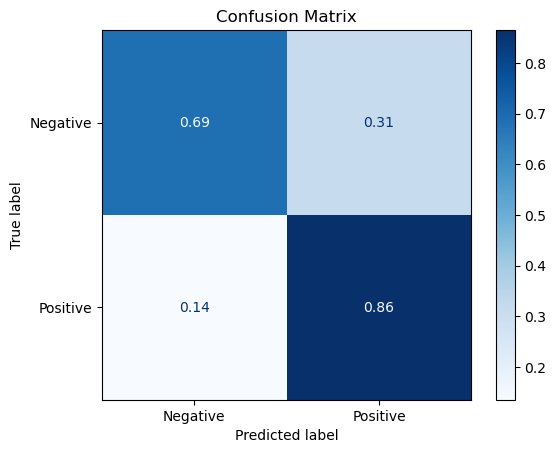

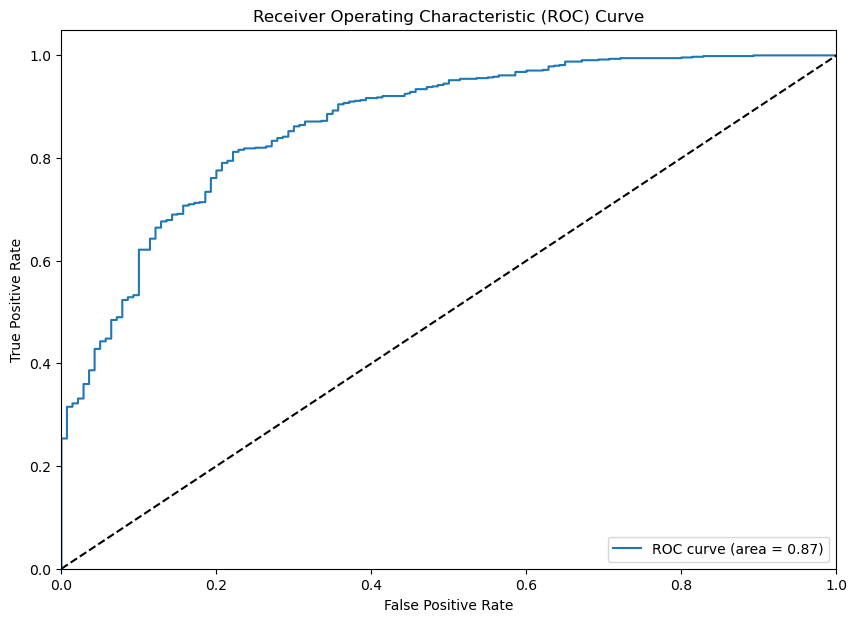

In [206]:
clf_pipe_oversample = ImbPipeline([
    ('vectorizer', TfidfVectorizer(stop_words = 'english',norm='l2')),  # Text vectorization
    ('oversample', RandomOverSampler()),  # Minority oversampling
    ('clf', MultinomialNB())  # Multinomial Naive Bayes classifier
])

param_grid = {
    'clf__alpha': [1.0],
    'clf__fit_prior': [True],
    'vectorizer__max_df': [0.5],
    'vectorizer__max_features': [5000],
    'vectorizer__min_df': [1],
    'vectorizer__ngram_range': [(1, 1)],
    'vectorizer__stop_words': [None]
}
grid_search = GridSearchCV(estimator=clf_pipe_oversample, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose = 10,error_score='raise')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model_NB = grid_search.best_estimator_

# Predict with the best model
y_pred = best_model_NB.predict(X_test)

print("Best parameters found:")
print(grid_search.best_params_)


# Evaluate the best model
evaluate_model_binary(y_test, y_pred, best_model_NB)

# Random Forest
- Hypertuned
- Minority class oversampling

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found:
{'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'vectorizer__max_df': 0.85, 'vectorizer__min_df': 2, 'vectorizer__ngram_range': (1, 2), 'vectorizer__stop_words': None}
Classification Report:
              precision    recall  f1-score   support

          -1       0.78      0.35      0.48       140
           1       0.89      0.98      0.93       745

    accuracy                           0.88       885
   macro avg       0.83      0.67      0.71       885
weighted avg       0.87      0.88      0.86       885



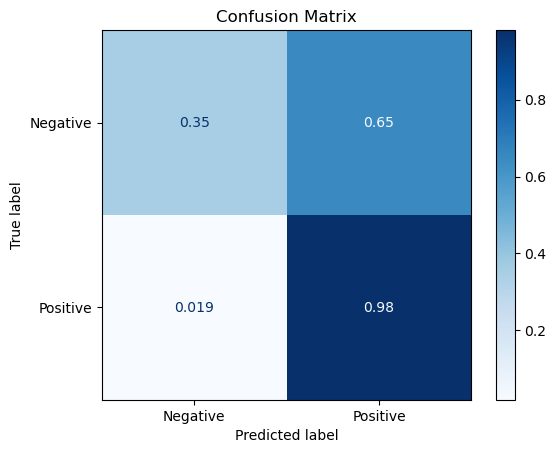

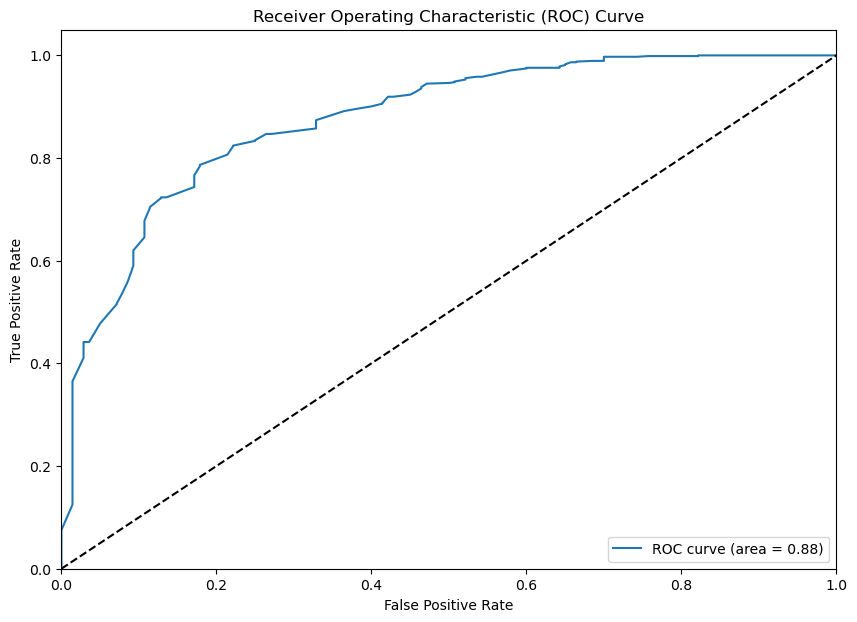

In [207]:
from sklearn.ensemble import RandomForestClassifier

clf_pipe = ImbPipeline([
    ('vectorizer', TfidfVectorizer(stop_words = 'english',norm='l2')),  # Placeholder parameters, will be tuned
    ('oversample', RandomOverSampler()),  # Minority oversampling
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))  # Placeholder parameters, will be tuned
])

param_grid = {
    'clf__max_depth': [None],
    'clf__max_features': ['sqrt'],
    'clf__min_samples_leaf': [1],
    'clf__min_samples_split': [2],
    'vectorizer__max_df': [0.85],
    'vectorizer__min_df': [2], 
    'vectorizer__ngram_range': [(1, 2)],
    'vectorizer__stop_words': [None],
        # Parameters for TfidfVectorizer
    'vectorizer__max_df': [0.75, 0.85, 1.0],  # Max document frequency for the terms
    'vectorizer__min_df': [1, 2, 3],  # Min document frequency for the terms
    'vectorizer__ngram_range': [(1, 1), (1, 2)],  # Range of n-grams to include
    'vectorizer__stop_words': [None, 'english'],  # Stop words to remove

}
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=clf_pipe, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose = 5)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found:")
print(grid_search.best_params_)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Predict with the best model
y_pred = best_model.predict(X_test)

evaluate_model_binary(y_test, y_pred, best_model)


# Logistic Regression
- Hypertuned
- Minority class oversampling

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:
{'clf__Cs': 10, 'clf__cv': 5, 'clf__max_iter': 100, 'vectorizer__max_df': 0.75, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2), 'vectorizer__stop_words': None}
Classification Report:
              precision    recall  f1-score   support

          -1       0.74      0.46      0.56       140
           1       0.90      0.97      0.94       745

    accuracy                           0.89       885
   macro avg       0.82      0.71      0.75       885
weighted avg       0.88      0.89      0.88       885



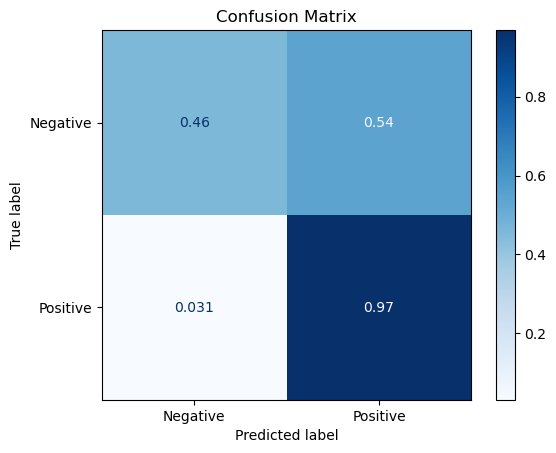

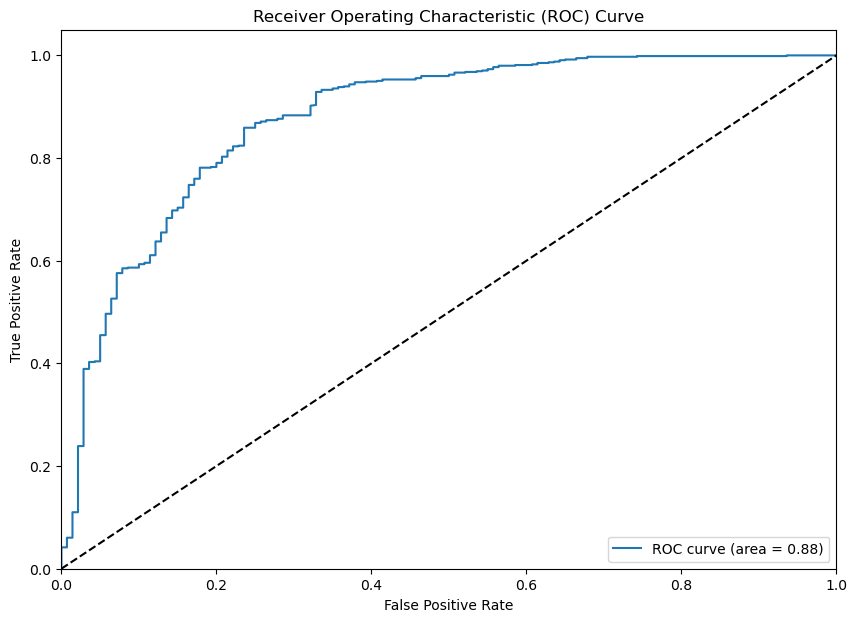

In [208]:
clf_pipe = ImbPipeline([
    ('vectorizer', TfidfVectorizer(stop_words = 'english',norm='l2')),  # Placeholder parameters, will be tuned
    ('oversample', RandomOverSampler()),  # Minority oversampling
    ('clf', LogisticRegressionCV(class_weight='balanced', random_state=42, 
                                 cv=3, Cs=1, solver='liblinear'))])

# Define the parameter grid
param_grid = {
    'clf__Cs': [10],  # Number of regularization parameters
    'clf__cv': [5],  # Number of folds in cross-validation
    'clf__max_iter': [100],  # Maximum number of iterations
    'vectorizer__max_df': [0.75], 
    'vectorizer__min_df': [1],
    'vectorizer__ngram_range': [ (1, 2)], 
    'vectorizer__stop_words': [None]
}


# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=clf_pipe, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=5)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found:")
print(grid_search.best_params_)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Predict with the best model
y_pred = best_model.predict(X_test)

# Evaluate the best model
evaluate_model_binary(y_test, y_pred, best_model)

# XGBoost
- Hypertuned
- Minority class oversampling

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:
{'clf__colsample_bytree': 0.8, 'clf__gamma': 0.3, 'clf__learning_rate': 0.1, 'clf__max_depth': 7, 'clf__min_child_weight': 1, 'clf__n_estimators': 200, 'clf__reg_alpha': 0.1, 'clf__reg_lambda': 1, 'clf__subsample': 0.8}
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.50      0.49       140
           1       0.91      0.90      0.90       745

    accuracy                           0.84       885
   macro avg       0.69      0.70      0.70       885
weighted avg       0.84      0.84      0.84       885



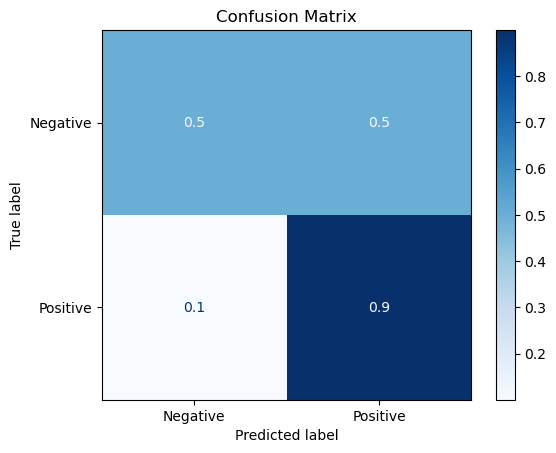

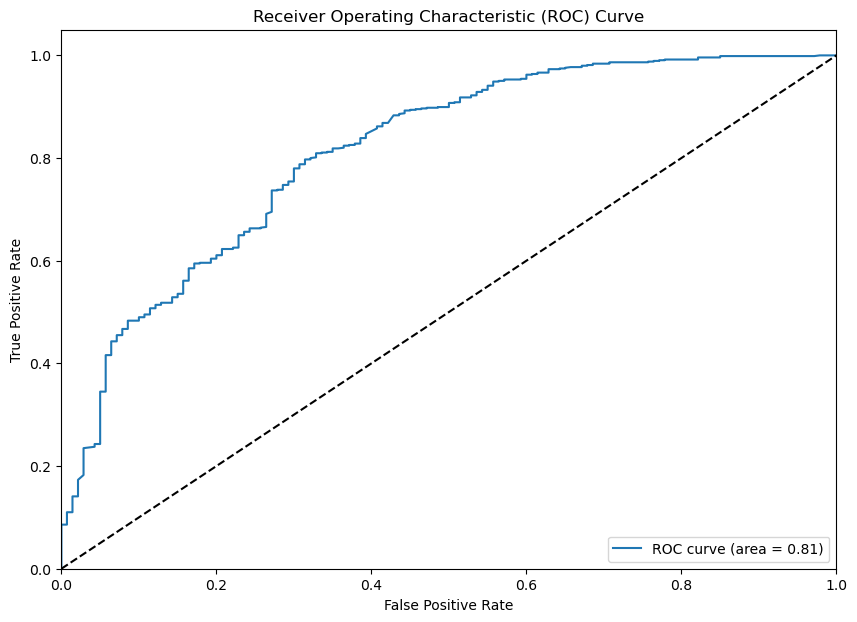

In [209]:
from xgboost import XGBClassifier

y_train_binary = np.where(y_train == -1, 0, y_train)
y_test_binary = np.where(y_test == -1, 0, y_test)

# Define the pipeline with XGBoost classifier
clf_pipe_oversample = ImbPipeline([
    ('vectorizer', TfidfVectorizer(stop_words = 'english',norm='l2')),  # Text vectorization
    ('oversample', RandomOverSampler()),  # Minority oversampling
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))  # XGBoost classifier
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'clf__colsample_bytree': [0.8],
    'clf__gamma': [0.3],
    'clf__learning_rate': [0.1],
    'clf__max_depth': [7],
    'clf__min_child_weight': [1],
    'clf__n_estimators': [200],
    'clf__reg_alpha': [0.1],
    'clf__reg_lambda': [1],
    'clf__subsample': [0.8]
}
# Set up GridSearchCV
grid_search = GridSearchCV(estimator=clf_pipe_oversample, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=10, error_score='raise')

# Fit GridSearchCV
grid_search.fit(X_train, y_train_binary)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Predict with the best model
y_pred = best_model.predict(X_test)

print("Best parameters found:")
print(grid_search.best_params_)

# Evaluate the best model
evaluate_model_binary(y_test_binary, y_pred, best_model)

## Model Performance Summary

The MultinomialNB model was the best performer, achieving an accuracy of 83%. Precision and Recall is more or less simmilar, the models do not seem to have a higher score in either category. The other Binary models had precision/recall scores that were way too low to use, which is why I chose multinomialNB as my best model

We will now proceed by incorporating neutral sentiment and transitioning to multi-class classification to further enhance our analysis.

In [210]:
def evaluate_model_multi(y_true, y_pred, model, X_test, n_class=3):

    print(classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive']))
    cm = confusion_matrix(y_true, y_pred, labels=[-1, 0, 1])
    
    # Normalize the confusion matrix by row (i.e., by the number of samples in each class)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - Multi-class')
    plt.show()
    
    # Binarize the output
    y_true_bin = label_binarize(y_true, classes=[-1, 0, 1])
    y_pred_prob = model.predict_proba(X_test)
    
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    plt.figure(figsize=(10, 7))
    
    # Labels for classes
    class_labels = ['Negative', 'Neutral', 'Positive']
    
    for i in range(n_class):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'ROC curve for {class_labels[i]} (area = {roc_auc[i]:.2f})')
    
    # Plot ROC curve for the model
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='best')
    plt.show()

In [211]:
data_multi = data.copy()
X = data_multi['tweet']
y = data_multi['emotion']

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


# Milti-Class RandomForest

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:
{'clf__max_depth': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5, 'clf__n_estimators': 200, 'vectorizer__max_df': 0.75, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2), 'vectorizer__stop_words': None}
              precision    recall  f1-score   support

    Negative       0.65      0.26      0.37       156
     Neutral       0.70      0.83      0.76      1333
    Positive       0.59      0.45      0.51       739

    accuracy                           0.67      2228
   macro avg       0.64      0.52      0.55      2228
weighted avg       0.66      0.67      0.65      2228



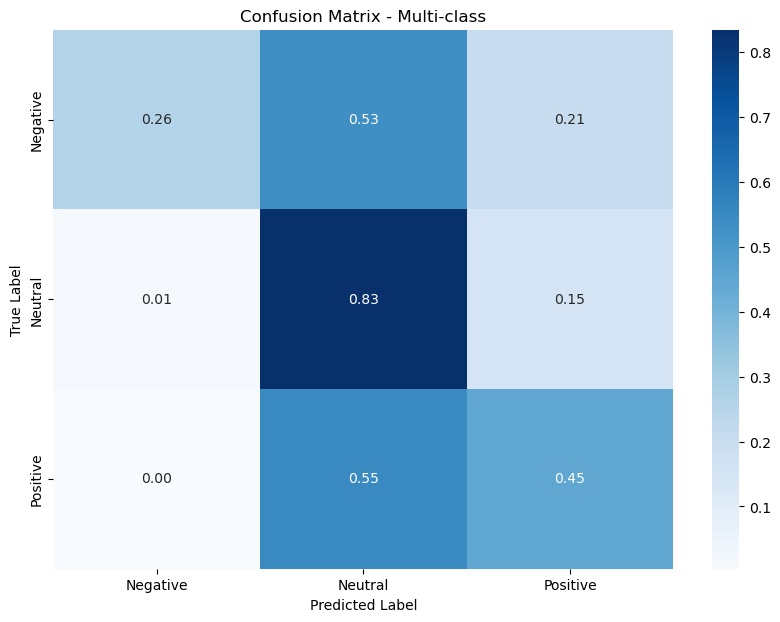

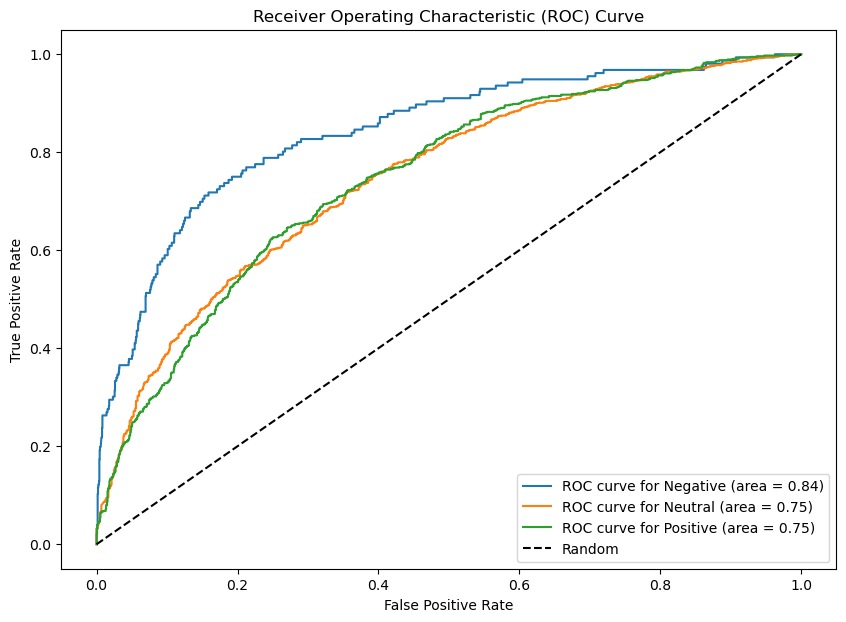

In [212]:
clf_pipe = ImbPipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english', norm='l2')),
    ('oversample', RandomOverSampler()),
    ('clf', RandomForestClassifier(random_state=42))  # Random Forest Classifier
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'vectorizer__max_df': [0.75], 
    'vectorizer__min_df': [1],
    'vectorizer__ngram_range': [(1, 2)], 
    'vectorizer__stop_words': [None],
    'clf__n_estimators': [200],  # Number of trees in the forest
    'clf__max_depth': [None],  # Max depth of the tree
    'clf__min_samples_split': [5],  # Minimum number of samples required to split an internal node
    'clf__min_samples_leaf': [2]    # Minimum number of samples required to be at a leaf node
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=clf_pipe, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=5)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found:")
print(grid_search.best_params_)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Predict with the best model
y_pred = best_model.predict(X_test)
evaluate_model_multi(y_test, y_pred, best_model, X_test, n_class=3)

In [213]:
y_train.value_counts()

emotion
 0    4039
 1    2229
-1     413
Name: count, dtype: int64

# Multi-Class MultinomialNB

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:
{'clf__alpha': 0.1, 'clf__fit_prior': False, 'vectorizer__binary': True, 'vectorizer__lowercase': True, 'vectorizer__max_df': 0.5, 'vectorizer__max_features': None, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2), 'vectorizer__smooth_idf': True, 'vectorizer__stop_words': None, 'vectorizer__sublinear_tf': True, 'vectorizer__use_idf': False}
              precision    recall  f1-score   support

    Negative       0.44      0.47      0.45       156
     Neutral       0.77      0.70      0.73      1333
    Positive       0.56      0.63      0.59       739

    accuracy                           0.66      2228
   macro avg       0.59      0.60      0.59      2228
weighted avg       0.67      0.66      0.67      2228



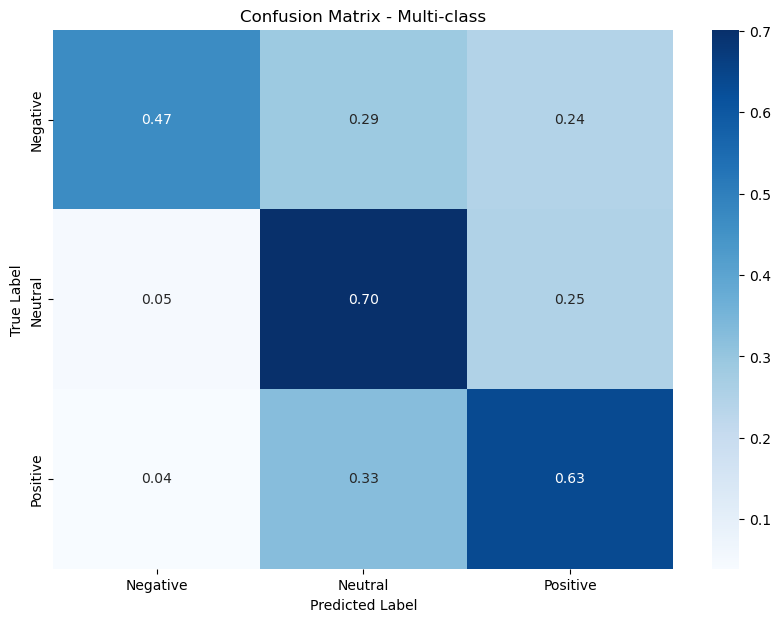

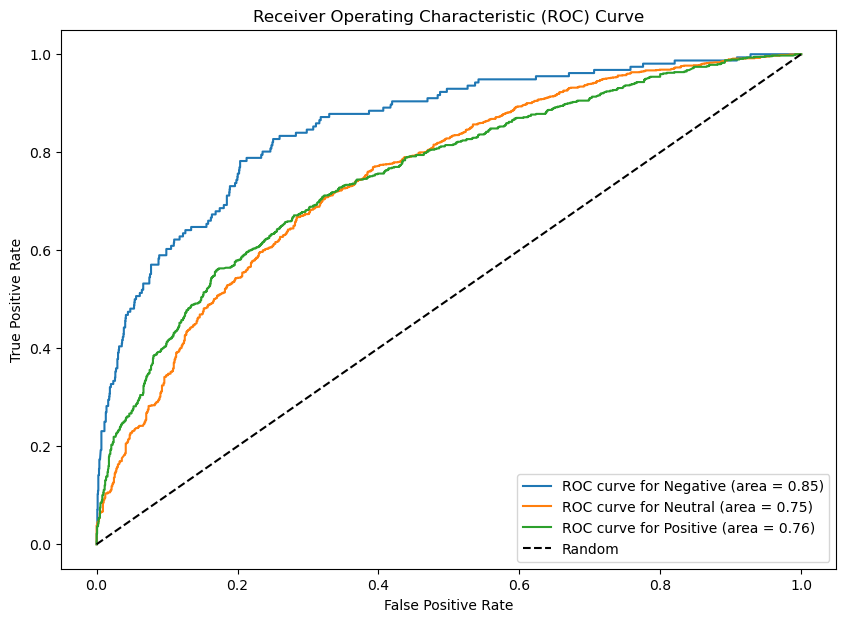

In [214]:
clf_pipe = ImbPipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english', norm='l2')),
    ('oversample', RandomOverSampler()),
    ('clf', MultinomialNB())  # MultinomialNB Classifier
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'clf__alpha': [0.1],
    'clf__fit_prior': [False],
    'vectorizer__binary': [True],
    'vectorizer__lowercase': [True],
    'vectorizer__max_df': [0.5],
    'vectorizer__max_features': [None],
    'vectorizer__min_df': [1],
    'vectorizer__ngram_range': [(1, 2)],
    'vectorizer__smooth_idf': [True],
    'vectorizer__stop_words': [None],
    'vectorizer__sublinear_tf': [True],
    'vectorizer__use_idf': [False]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=clf_pipe, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=5)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found:")
print(grid_search.best_params_)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Predict with the best model
y_pred = best_model.predict(X_test)

evaluate_model_multi(y_test, y_pred, best_model, X_test, n_class=3)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:
{'clf__Cs': 10, 'vectorizer__max_df': 0.75, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 1)}
              precision    recall  f1-score   support

    Negative       0.44      0.37      0.40       156
     Neutral       0.74      0.75      0.74      1333
    Positive       0.58      0.58      0.58       739

    accuracy                           0.67      2228
   macro avg       0.58      0.57      0.57      2228
weighted avg       0.66      0.67      0.66      2228



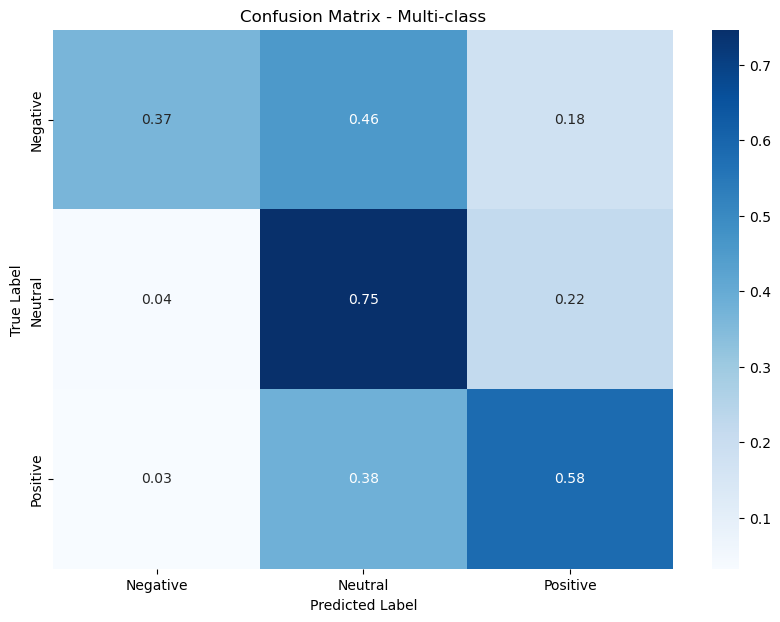

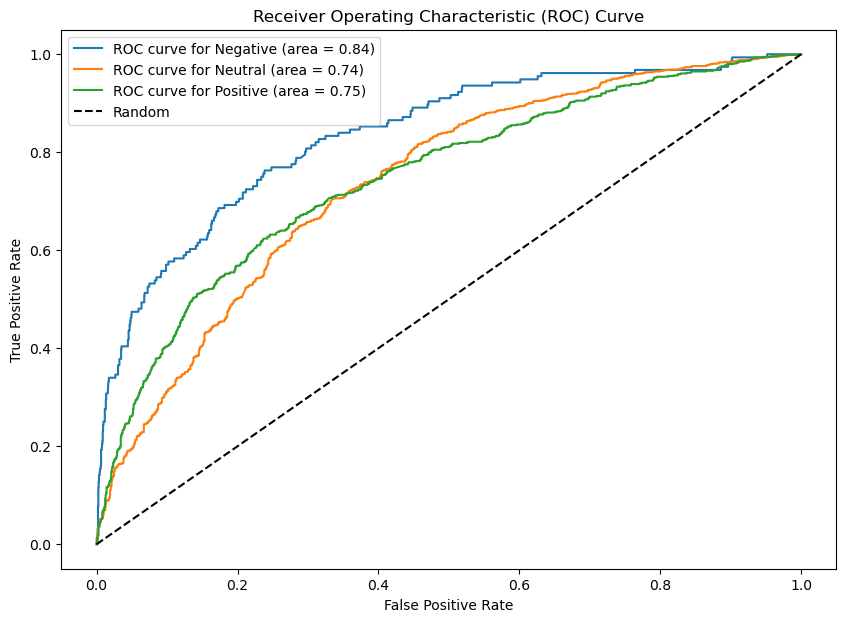

In [215]:
clf_pipe = ImbPipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english', norm='l2')),
    ('oversample', RandomOverSampler()),  # Apply oversampling
    ('clf', LogisticRegressionCV(max_iter=1000, cv=5))  # Logistic Regression with cross-validation
])

# Define the parameter grid for GridSearchCV
param_grid = {
    # Parameters for TfidfVectorizer
    'vectorizer__max_df': [0.75], 
    'vectorizer__min_df': [1],
    'vectorizer__ngram_range': [(1, 1)], 

    # Parameters for LogisticRegressionCV
    'clf__Cs': [10],  # Regularization strength (inverse of C)
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=clf_pipe, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=5)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found:")
print(grid_search.best_params_)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Predict with the best model
y_pred = best_model.predict(X_test)

# Evaluate the model
evaluate_model_multi(y_test, y_pred, best_model, X_test, n_class=3)

## Multi-Class Model Performance

The multiclass classifiers performed worse than the binary models. They struggled to differentiate between positive and neutral sentiments effectively. Additionally, the inclusion of neutral tweets appeared to be counterproductive, introducing hesitation and reducing overall model performance. Once again, MultinomialNB had much better precision and recall scores, which is why it seems to be the best multi-class model.

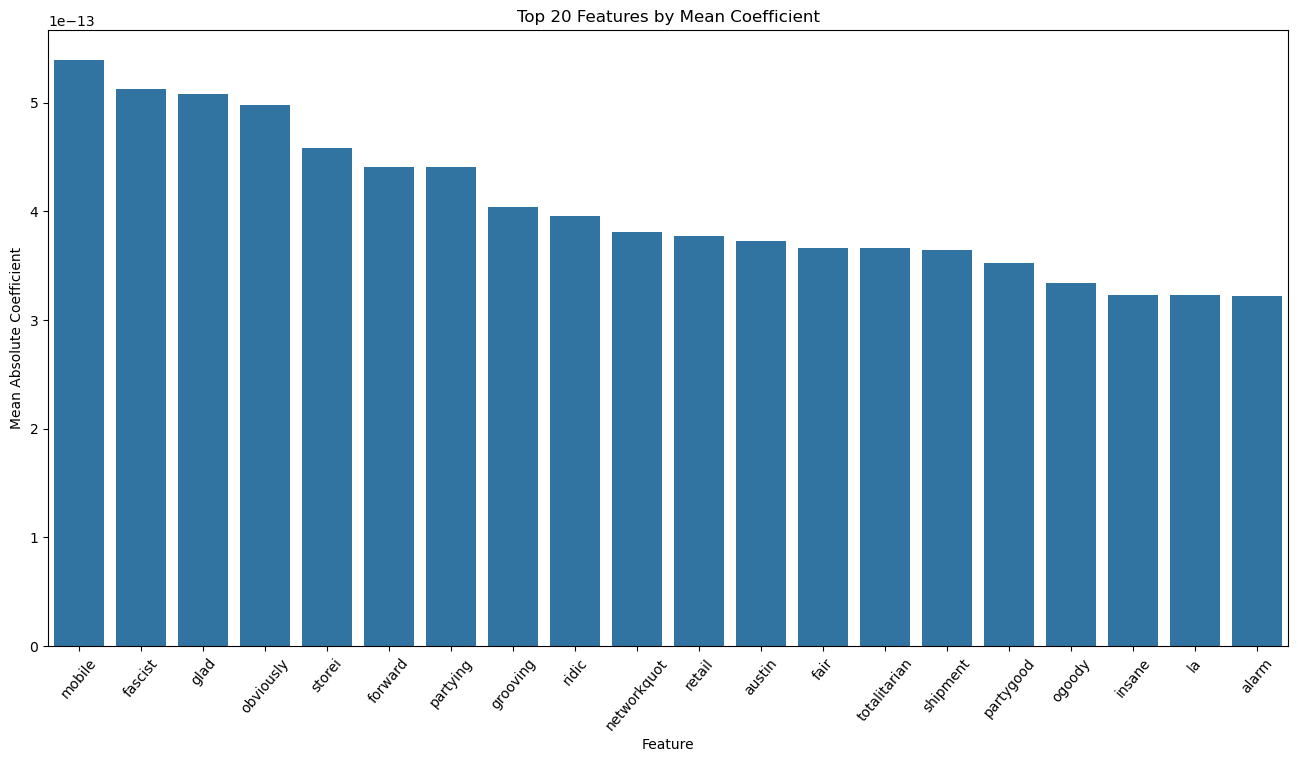

In [216]:
best_model = grid_search.best_estimator_

# Get the feature names from the vectorizer
feature_names = best_model.named_steps['vectorizer'].get_feature_names_out()

# Get the coefficients from the best model
coefficients = best_model.named_steps['clf'].coef_

# Create a DataFrame to store feature importance for each class
coef_df = pd.DataFrame(coefficients.T, columns=[f'Class {i}' for i in range(coefficients.shape[0])], index=feature_names)

# Define a list of words to redact
words_to_redact = ['hm', 'shite', 'fuck', 'launchquot', 'gtgreally']  # I'm presenting this, no naughty words

# Filter out the words from the DataFrame
coef_df_filtered = coef_df.loc[~coef_df.index.isin(words_to_redact)]

# Calculate the mean absolute coefficients and sort
top_features = coef_df_filtered.mean(axis=1).sort_values(ascending=False)

# Plot the top features
plt.figure(figsize=(16, 8))
sns.barplot(x=top_features.head(20).index, y=top_features.head(20).values)
plt.xticks(rotation=50)
plt.title('Top 20 Features by Mean Coefficient')
plt.xlabel('Feature')
plt.ylabel('Mean Absolute Coefficient')
plt.show()

## Model Explanation

### Model Overview

In this analysis, we employed the **Multi-Class MultinomialNB** classifier to classify tweets into three sentiment categories: positive, negative, and neutral. We also used the **Binary MultinomialNB** classifier to classify tweets with positive and negative sentiments.

### Milti-Class Performance Insights

- **Best Performance on Negative Sentiment**: The MultinomialNB model demonstrated high accuracy in predicting negative sentiment tweets. This suggests that the model is particularly effective at identifying and classifying tweets with negative sentiments.

- **Challenges with Neutral and Positive Sentiments**: Incorporating neutral tweets into the model introduced some difficulties in distinguishing between neutral and positive sentiment tweets. The model's performance in differentiating between these two categories became less effective, indicating that the presence of neutral sentiment may have created some confusion in classification.

- **Binary Classifier Superiority**: The binary MultinomialNB classifier outperformed the multi-class model in terms of accuracy for distinguishing between positive and negative sentiments. The binary classifier achieved better performance in identifying and differentiating these two sentiment classes, demonstrating a clearer contrast and improving overall classification accuracy.

### Summary

While the Multi-class MultinomialNB classifier excels at identifying negative sentiment, it faces challenges when distinguishing between neutral and positive sentiments. This behavior highlights the need for further refinement, possibly through additional preprocessing or feature engineering, to improve classification accuracy across all sentiment categories. Our binary MultinomialNB model performed better overall, particularly in differentiating between positive and negative tweets.

### Recommendations

For companies looking to analyze tweet sentiment related to their brand, it is advisable to use the binary MultinomialNB model. This model can be employed to determine the sentiment of tweets after scraping Twitter for relevant mentions. The binary classification approach will provide more useful insights into positive versus negative sentiments, which are crucial for understanding public perception and tailoring communication strategies. By focusing on these two sentiment classes, companies can better assess and respond to feedback, enhancing their engagement with customers and stakeholders.


# Conclusion

The multi-output model demonstrates strong performance in predicting negative tweets, yet it faces challenges in distinguishing between positive and neutral tweets. Although the model is capable of capturing all three sentiment values (positive, neutral, and negative), its performance is inferior to that of the binary classifier. This discrepancy is likely due to the reduced contrast between the three sentiment classes compared to the higher contrast observed between positive and negative sentiments in the binary classification scenario.

Given that neutral tweets do not significantly contribute to the model's effectiveness and that differentiating between positive and negative tweets is more valuable, we recommend using the binary classifier. This approach will likely yield better performance and more meaningful insights into sentiment analysis.

# Next Steps

1. Increase Dataset Size

    The current dataset was relatively small and showed a bias towards positive sentiment. Random oversampling had to be used to balance the dataset, however capturing real data is mush better. To improve model performance and generalizability, we should consider expanding the dataset to include a larger number of tweets. This will help capture a wider range of sentiment expressions and make the model more robust.

2. Ensure Dataset Balance

    The dataset exhibited an imbalance, with most tweets having positive sentiment. Future work should involve gathering a more balanced dataset, with approximately equal representation of all sentiment classes (positive, neutral, negative). This will help in training a more accurate and fair model.


3. Enhance Preprocessing and Feature Engineering

    Investigate advanced preprocessing techniques and feature engineering methods to improve model performance. Experiment with different tokenization methods, embeddings, and text normalization techniques to capture the nuances of sentiment in tweets better.

4. Explore Alternative Models

    Experiment with different types of models and algorithms to determine if they perform better with the given dataset. For instance, deep learning models like LSTMs, GRUs, or Transformers might offer improved performance over traditional methods.


5. Develop additional models to build off of sentiment classification

    Models that can find trends within tweets containing positive or negative sentiment can pinpoint an exact term that causes the emotions. Using term analysis could be extra benificial, since specific terms responsible for sentiment classification could be identified.
   